# Compare a few regional projections

In [76]:
import sys
sys.path.append('../code')

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs

import func_postpro as pp

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

### Build a common dataset including all projections

In [73]:
data_dir = '../outputs/'
proj_names = ['Low', 'Medium', 'High']
suff = 'SeaLevelMap_RECEIPT_D73_'
proj_files = [f'{suff}LowMed_ssp126_GISS-E2-1-G_Perc5_2006_2125.nc',
              f'{suff}LowMed_ssp245_mean_Perc50_2006_2125.nc',
              f'{suff}High_ssp585_UKESM1-0-LL_Perc95_2006_2125.nc']

proj_ds_list = []
for i in range(len(proj_files)):
    ds = xr.open_dataset(f'{data_dir}{proj_files[i]}')
    ds = ds.expand_dims({'proj': [proj_names[i]]})
    proj_ds_list.append(ds)

proj_ds = xr.concat(proj_ds_list, dim='proj')

In [18]:
proj_ds

<xarray.Dataset>
Dimensions:             (lat: 180, lon: 360, proc_s: 8, proj: 3, time: 120)
Coordinates:
  * proj                (proj) <U6 'Low' 'Medium' 'High'
  * time                (time) int64 2006 2007 2008 2009 ... 2122 2123 2124 2125
  * proc_s              (proc_s) object 'Stero-dynamics' 'Glaciers' ... 'GIA'
  * lat                 (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    slc                 (proj, time, proc_s, lat, lon) float64 nan nan ... 15.37
    TotalSL             (proj, time, lat, lon) float64 nan nan ... 61.39 61.39
    area_weighted_mean  (proj, time) float64 2.367 2.657 2.939 ... 231.3 235.9
Attributes:
    source_file:    This NetCDF file was built from BuildTotalSeaLevelMaps.py
    creation_date:  2021-08-03 17:09

In [70]:
# Take the mean over a region
# lon_min, lon_max, lat_min, lat_max = pp.define_area('knmi14_reg')
lon_min, lon_max, lat_min, lat_max = 6, 9, 53, 55 # German coast for Xaver
proj_mean_ds = proj_ds.sel(lat=slice(lat_min, lat_max), 
                           lon=slice(lon_min, lon_max)
                          ).mean(dim=['lat', 'lon'])

# Select one grid cell
# lon_s, lat_s = 7.5, 54.5
# proj_mean_ds = proj_ds.sel(lat=lat_s, lon=lon_s, method='nearest')

In [71]:
proj_mean_ds

<xarray.Dataset>
Dimensions:             (proc_s: 8, proj: 3, time: 120)
Coordinates:
  * proj                (proj) <U6 'Low' 'Medium' 'High'
  * time                (time) int64 2006 2007 2008 2009 ... 2122 2123 2124 2125
  * proc_s              (proc_s) object 'Stero-dynamics' 'Glaciers' ... 'GIA'
Data variables:
    slc                 (proj, time, proc_s) float64 0.9416 0.6677 ... 13.58
    TotalSL             (proj, time) float64 3.036 3.381 3.72 ... 236.7 233.1
    area_weighted_mean  (proj, time) float64 2.367 2.657 2.939 ... 231.3 235.9

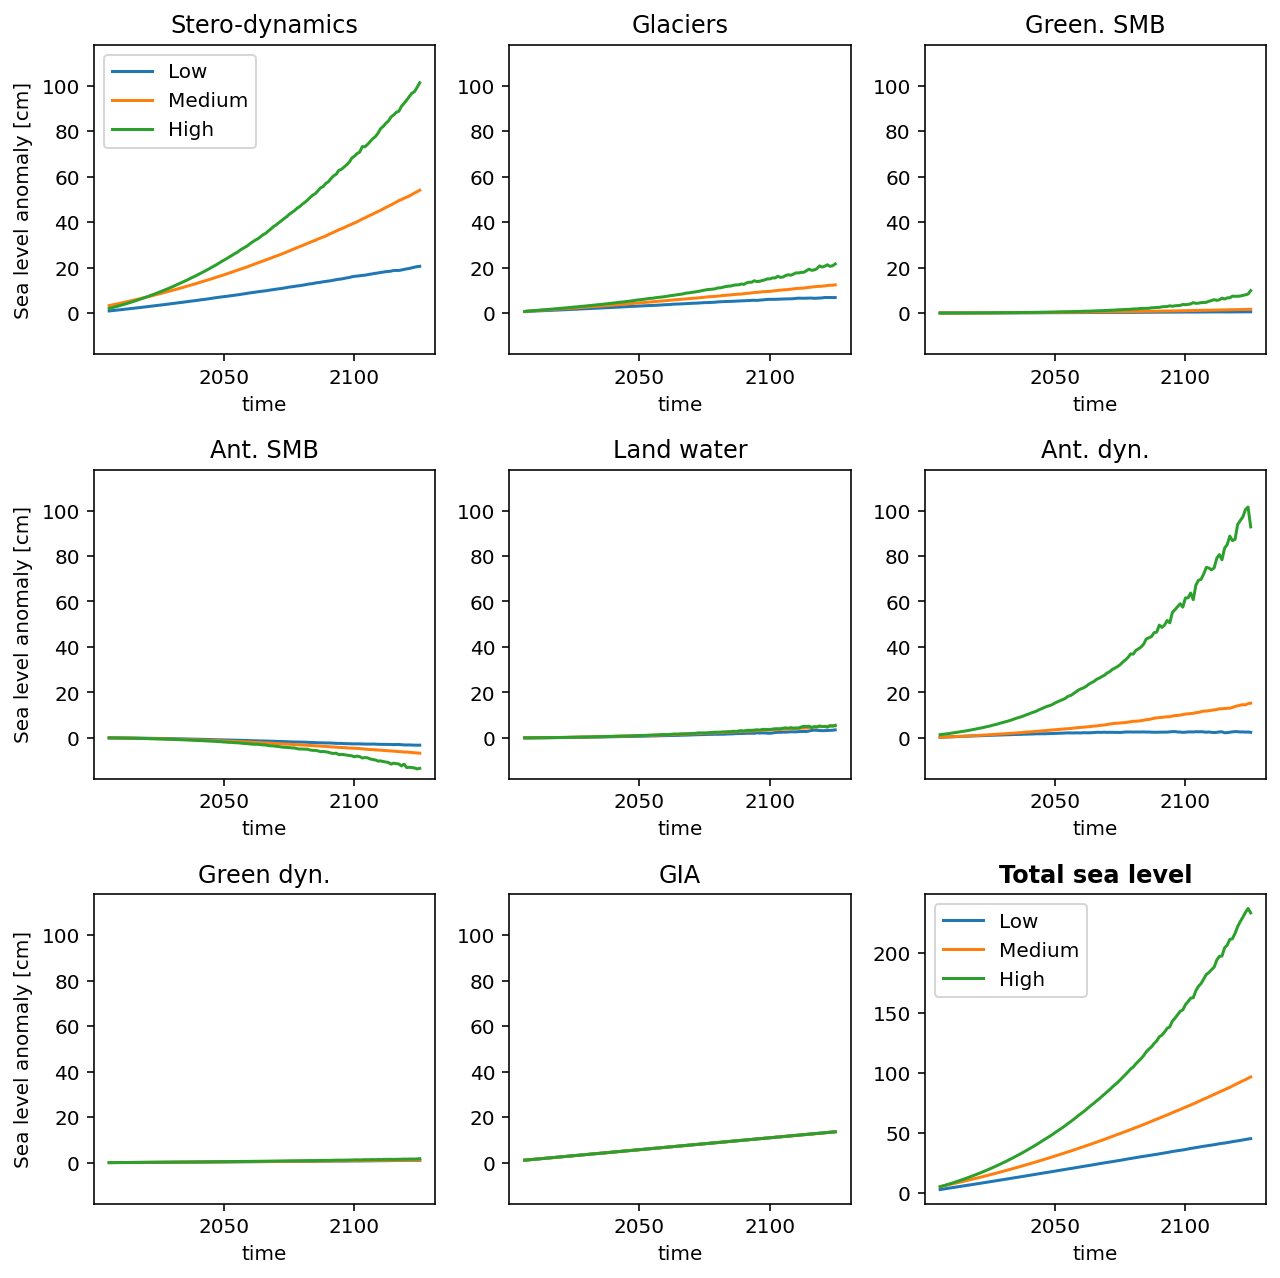

In [127]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9,9))

for i in range(len(proj_mean_ds.proc_s)):
    proj_mean_ds.slc.isel(proc_s=i).plot.line(x='time', ax=axes.flat[i])
    axes.flat[i].set_title(proj_mean_ds.proc_s[i].values)
    axes.flat[i].set_ylim(-18,118)
    legend = axes.flat[i].get_legend()
    legend.set_title('')

    if i>0:
        legend.remove()

proj_mean_ds.TotalSL.plot.line(x='time', ax=axes.flat[-1])
axes.flat[-1].set_title('Total sea level', fontweight='bold')
legend = axes.flat[-1].get_legend()
legend.set_title('')

for i in range(3):
    axes[i,0].set_ylabel('Sea level anomaly [cm]')
    axes[i,1].set_ylabel('')
    axes[i,2].set_ylabel('')

plt.tight_layout()

#plt.savefig(f'../figures/CompContrib_Xaver.pdf', dpi=100)

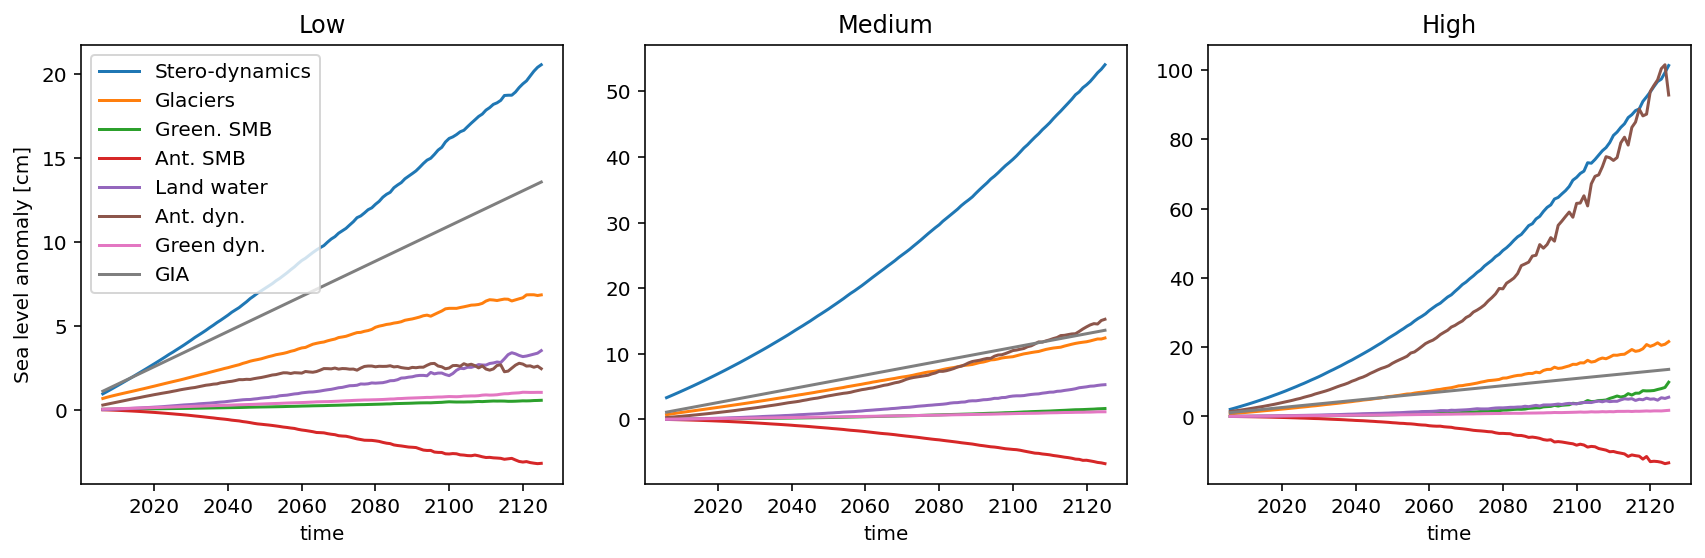

In [126]:
fig, axes = plt.subplots(ncols=3, figsize=(12,4))

for i in range(len(proj_mean_ds.proj)):
    proj_mean_ds.slc.isel(proj=i).plot.line(x='time', ax=axes[i])
    axes[i].set_title(proj_mean_ds.proj[i].values)

    legend = axes[i].get_legend()
    legend.set_title('')
    
    if i==0:
        axes[i].set_ylabel('Sea level anomaly [cm]')
    else:
        axes[i].set_ylabel('')
        legend.remove()

plt.tight_layout()

#plt.savefig(f'../figures/CompScen_Xaver.pdf', dpi=100)

In [100]:
legend = axes[0].get_legend()
legend.set_title('test')

### Maps of future sea level

In [78]:
proj_map_ds = proj_ds.TotalSL.sel(time=slice(2120,2125)).mean(dim='time')

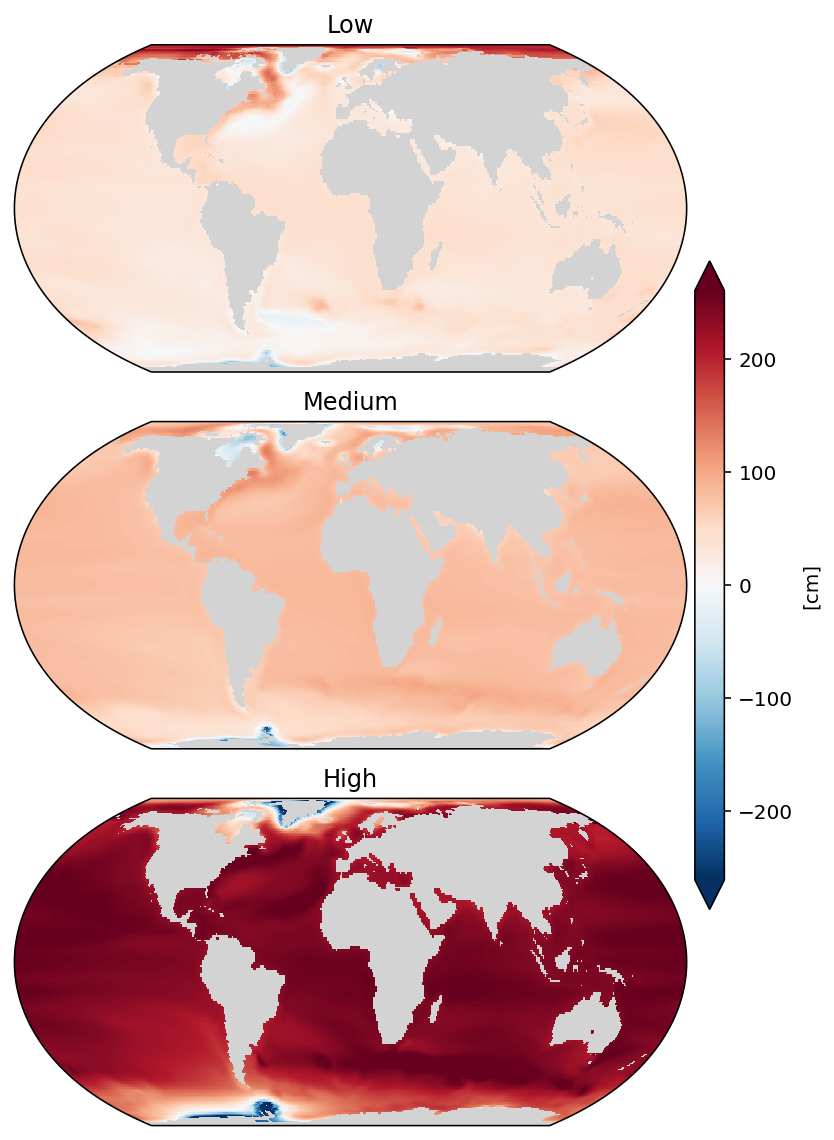

In [81]:
g = proj_map_ds.plot(
    col='proj',
    col_wrap=1,
    figsize=(6,8),
    #Projections options: PlateCarree, Mollweide, Robinson, EckertIV, EqualEarth
    subplot_kws=dict(projection=ccrs.EqualEarth(), facecolor="lightgray"),
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'orientation': 'vertical', 'label': '[cm]', 'pad': 0.01, 'shrink':0.6},
    robust=True
    )

for i in range(3):
    g.axes[i,0].set_title(proj_names[i]) #Index of axis is line,column 

#plt.savefig(f'../figures/CompMapProj_world.pdf', dpi=100)

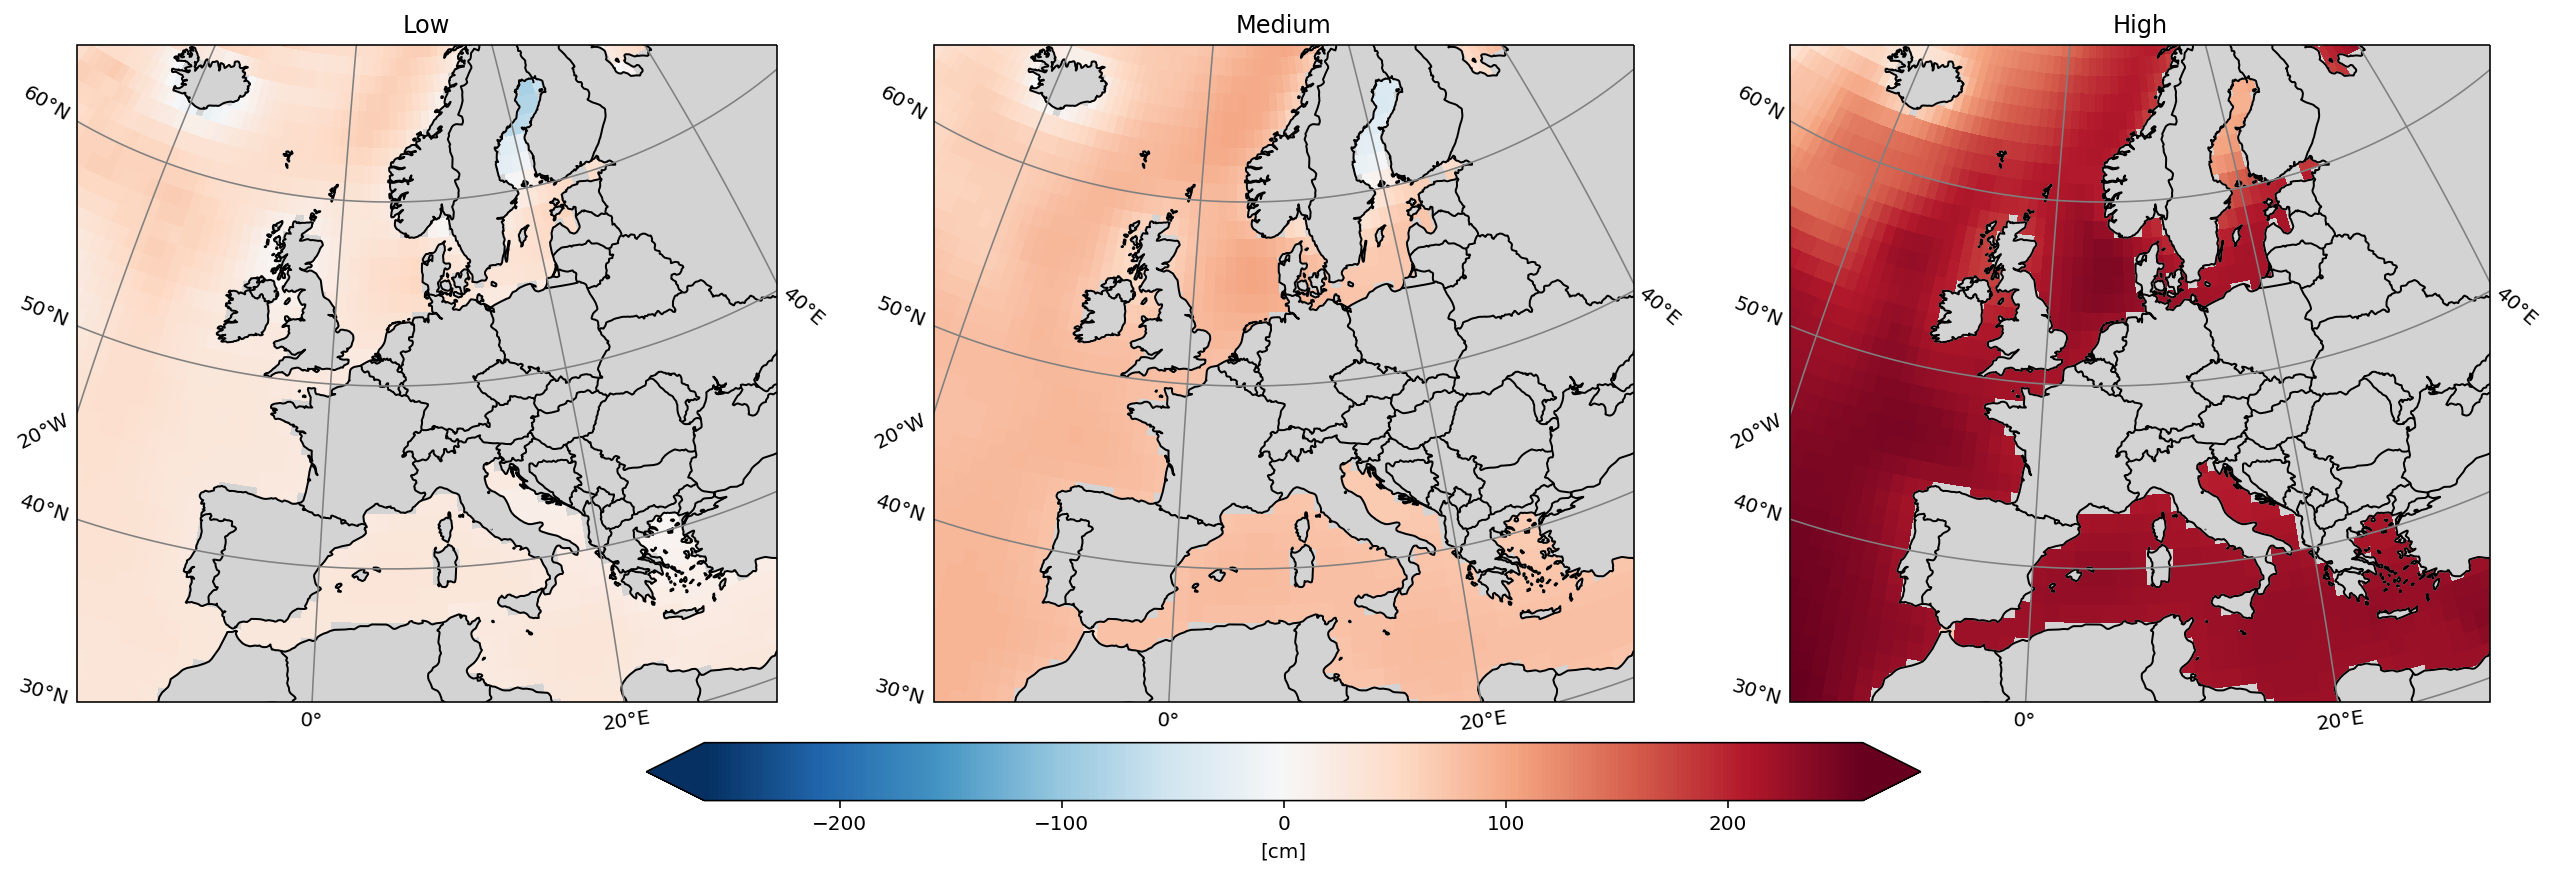

In [115]:
lon_min, lon_max, lat_min, lat_max = -15, 30, 30, 67

#g = concat_mean.sel(lat=slice(lat_min,lat_max+2), lon=slice(lon_min-10,lon_max)).plot(
g = proj_map_ds.plot(
    col='proj',
    figsize=(18,6),
    subplot_kws=dict(projection=ccrs.Orthographic(5, 52), facecolor="lightgray"),
    transform=ccrs.PlateCarree(),
    cbar_kwargs={'orientation': 'horizontal', 'label': '[cm]', 'pad': 0.05, 'shrink':0.5},
    robust=True
    )

for i in range(3):
    g.axes[0,i].set_title(proj_names[i]) #Index of axis is line,column 

    g.axes[0,i].add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1) #zorder=1    
    g.axes[0,i].add_feature(cfeature.BORDERS)
    g.axes[0,i].coastlines()

    gl = g.axes[0,i].gridlines(color='grey', linestyle='-', draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
    g.axes[0,i].set_extent([lon_min, lon_max, lat_min, lat_max])
    
plt.savefig(f'../figures/CompMapProj_europe.pdf', dpi=100, bbox_inches='tight')